# Statistical Data Analysis Project - Group 58

Maša Ćirković

Mete Harun Akçay

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, shapiro, spearmanr, chi2_contingency, mannwhitneyu, kruskal
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests

## Functions

In [ ]:
# Check the unique values for each column
def check_unique_values(df):
  for column in df.columns:
    unique_values = df[column].unique()
    print(f"Column '{column}':")
    print(unique_values)
    print("\n" + "-"*50 + "\n")

In [ ]:
# Function to convert 0 to 1.0 (no) and any other integer to 2.0 (yes)
def convert_number_to_1_or_2(value):
    if value in [1.0, 2.0]:
        return value  # Keep original values as they are
    elif isinstance(value, (int, float)) and value == 0:
        return 1.0 # Convert 0 to 1.0 which is no
    elif isinstance(value, (int, float)) and value != 0:
        return 2.0  # Convert any other number to 2.0 which is yes
    return None

# Function to transform timestamps to minutes
def time_to_minutes(value):
  if pd.isnull(value):  # Check for NaN or None values using pandas function
    return None
  elif isinstance(value, str) and ':' in value:  # Case 2: "HH:MM" format and ensure it's a string
    hours, minutes = map(int, value.split(':'))
    return hours * 60 + minutes  # Convert hours to minutes and add the minutes
  else:  # Case 1: "minutes" format or other numeric types
    return int(value)

In [ ]:
def countplots(x_columns, y_columns, titles, x_labels):
  length = len(x_columns)
  plt.figure(figsize=(6 * length, 6))
  for i in range(length):
    plt.subplot(1, length, i + 1)
    sns.countplot(data=df, x=x_columns[i], hue=y_columns[i])
    plt.title(titles[i])
    plt.xlabel(x_labels[i])
  plt.tight_layout()

def histoplots(x_columns, y_columns, titles, x_labels):
  length = len(x_columns)
  plt.figure(figsize=(6 * length, 6))
  for i in range(length):
    plt.subplot(1, length, i + 1)
    sns.histplot(data=df, x=x_columns[i], hue=y_columns[i], kde=True, edgecolor="black")
    plt.title(titles[i])
    plt.xlabel(x_labels[i])
  plt.tight_layout()

def kdeplots(x_columns, y_columns, titles, x_labels):
  length = len(x_columns)
  plt.figure(figsize=(6 * length, 6))
  for i in range(length):
    plt.subplot(1, length, i + 1)
    sns.kdeplot(data=df, x=x_columns[i], hue=y_columns[i], fill=False, warn_singular=False, clip=(0, None))
    plt.title(titles[i])
    plt.xlabel(x_labels[i])
  plt.tight_layout()

In [ ]:
def print_test_results(stat, p, H0, p_adj = None, alpha=0.05):
  if p_adj == None:
    print('Statistics=%.3f, p=%.3f' % (stat, p))
  else:
    print('Statistics=%.3f, p=%.3f, p_adj=%.3f' % (stat, p, p_adj))
    p = p_adj

  print(f"H0: {H0}")
  if p > alpha:
      print('Fail to reject H0. There is no statistically significant difference between the groups.')
  else:
      print('Reject H0. There is a statistically significant difference between the groups.')

def print_normality_test_results(data, H0, alpha=0.05):
  stat, p = shapiro(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  print(f"H0: {H0}")
  if p > alpha:
      print('Sample looks Gaussian (fail to reject H0)')
  else:
      print('Sample does not look Gaussian (reject H0)')

##Data Preparation

In [ ]:
with open("habits.txt", 'r') as file:
    contents = file.read()

print(contents)

-------
PREFACE
-------

This documentation and the related data files are
derived from the data set "Teaching use data of the
Time Use Survey" by Statistics Finland. The material
was downloaded from Statistics Finland's web site
(https://stat.fi/tup/tutkijapalvelut/opetusaineistot_en.html)
on 25 April 2024 with the Creative Commons
Attribution 4.0 International licence
(https://creativecommons.org/licenses/by/4.0/deed.en).



-------------
DOCUMENTATION
-------------

The data consists of 6 demographic variables and
18 activity variables. The variables are described
below, along with the values they may have.


Demographic variables
---------------------

kohde - household ID

jasen - member ID (within household)

pvknro - day of week
1 = working day
2 = weekend

sp - sex
1 = male
2 = female

IKAL1 - age group
1 = 10-14 years old
2 = 15-19 years old
3 = 20-24 years old
4 = 25-34 years old
5 = 35-44 years old
6 = 45-54 years old
7 = 55-64 years old
8 = 65-74 years old
9 = 75- years old

In [ ]:
data = pd.read_csv('habits.data', sep=';', na_values='?')
dataframe = data[['kohde', 'jasen', 'pvknro', 'sp', 'IKAL1', 'ASALUE', 'V1', 'V40', 'V7', 'V70', 'H1a_A', 'H1i_A']]
dataframe

,kohde,jasen,pvknro,sp,IKAL1,ASALUE,V1,V40,V7,V70,H1a_A,H1i_A
0,50002,1,2,1,6,1.0,380,0,0,130,2.0,1.0
1,50002,2,2,2,6,1.0,470,0,10,0,1.0,1.0
2,50009,1,2,2,7,1.0,350,0,10,120,1.0,1.0
3,50011,1,2,2,4,3.0,360,0,0,20,1.0,1.0
4,50012,1,1,2,8,1.0,0,0,70,350,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
775,51980,1,2,2,6,2.0,460,0,0,80,1.0,1.0
776,51981,1,2,2,5,1.0,0,0,0,160,1.0,1.0
777,51981,2,2,1,5,1.0,0,0,0,190,NaN,NaN
778,51982,1,2,2,6,1.0,0,0,0,210,2.0,2.0


In [ ]:
# Change columns to English & descriptive labels for clarity
df = dataframe.copy()

df.rename(columns={
    'kohde': 'household_ID',
    'jasen': 'member_ID',
    'pvknro': 'day',
    'sp': 'sex',
    'IKAL1': 'age',
    'ASALUE': 'place',
    'V1': 'working',
    'V40': 'studying',
    'V7': 'washing_dishes',
    'V70': 'watching_TV',
    'H1a_A': 'cinema',
    'H1i_A': 'sport'
}, inplace=True)

df['day'] = df['day'].map({1: 'working day', 2: 'weekend'}).astype('category')

df['sex'] = df['sex'].map({1: 'male', 2: 'female'}).astype('category')

df['age'] = df['age'].map({
    1: '10-14',
    2: '15-19',
    3: '20-24',
    4: '25-34',
    5: '35-44',
    6: '45-54',
    7: '55-64',
    8: '65-74',
    9: '75+'
}).astype('category')

df['place'] = df['place'].map({1: 'city', 2: 'municipality', 3: 'rural'}).astype('category')

df['member_ID'] = df['member_ID'].astype('category')

df['household_ID'] = df['household_ID'].astype('category')

df

,household_ID,member_ID,day,sex,age,place,working,studying,washing_dishes,watching_TV,cinema,sport
0,50002,1,weekend,male,45-54,city,380,0,0,130,2.0,1.0
1,50002,2,weekend,female,45-54,city,470,0,10,0,1.0,1.0
2,50009,1,weekend,female,55-64,city,350,0,10,120,1.0,1.0
3,50011,1,weekend,female,25-34,rural,360,0,0,20,1.0,1.0
4,50012,1,working day,female,65-74,city,0,0,70,350,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
775,51980,1,weekend,female,45-54,municipality,460,0,0,80,1.0,1.0
776,51981,1,weekend,female,35-44,city,0,0,0,160,1.0,1.0
777,51981,2,weekend,male,35-44,city,0,0,0,190,NaN,NaN
778,51982,1,weekend,female,45-54,city,0,0,0,210,2.0,2.0


In [ ]:
# Some values for cinema and sport are numbers other than 1.0 anf 2.0

df['cinema'] = df['cinema'].apply(convert_number_to_1_or_2)
df['sport'] = df['sport'].apply(convert_number_to_1_or_2)

df['cinema'] = df['cinema'].map({1.0: 'yes', 2.0: 'no'}).astype('category')
df['sport'] = df['sport'].map({1.0: 'yes', 2.0: 'no'}).astype('category')

df

,household_ID,member_ID,day,sex,age,place,working,studying,washing_dishes,watching_TV,cinema,sport
0,50002,1,weekend,male,45-54,city,380,0,0,130,no,yes
1,50002,2,weekend,female,45-54,city,470,0,10,0,yes,yes
2,50009,1,weekend,female,55-64,city,350,0,10,120,yes,yes
3,50011,1,weekend,female,25-34,rural,360,0,0,20,yes,yes
4,50012,1,working day,female,65-74,city,0,0,70,350,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...
775,51980,1,weekend,female,45-54,municipality,460,0,0,80,yes,yes
776,51981,1,weekend,female,35-44,city,0,0,0,160,yes,yes
777,51981,2,weekend,male,35-44,city,0,0,0,190,no,no
778,51982,1,weekend,female,45-54,city,0,0,0,210,no,no


In [ ]:
# Check for NaN values
df.isnull().sum()

,0
household_ID,0
member_ID,0
day,0
sex,0
age,0
place,0
working,5
studying,7
washing_dishes,12
watching_TV,8


In [ ]:
check_unique_values(df)

Column 'household_ID':
[50002, 50009, 50011, 50012, 50015, ..., 51977, 51978, 51980, 51981, 51982]
Length: 494
Categories (494, int64): [50002, 50009, 50011, 50012, ..., 51978, 51980, 51981, 51982]

--------------------------------------------------

Column 'member_ID':
[1, 2]
Categories (2, int64): [1, 2]

--------------------------------------------------

Column 'day':
['weekend', 'working day']
Categories (2, object): ['weekend', 'working day']

--------------------------------------------------

Column 'sex':
['male', 'female']
Categories (2, object): ['female', 'male']

--------------------------------------------------

Column 'age':
['45-54', '55-64', '25-34', '65-74', '20-24', '75+', '35-44']
Categories (7, object): ['20-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

--------------------------------------------------

Column 'place':
['city', 'rural', 'municipality']
Categories (3, object): ['city', 'municipality', 'rural']

-----------------------------------------

In [ ]:
# Some activity values are given in minutes, some are given in HH:MM format

for col in ['working', 'studying', 'washing_dishes', 'watching_TV']:
  df[col] = df[col].apply(time_to_minutes).astype('Int64')  # Convert to integer type, allowing NaNs

In [ ]:
# Impute missing values based on the mean of each group defined by 'sex', 'day', 'age', and 'place';
# if no group mean is available, use the overall column mean.

df_cleaned = df.copy()
columns_to_impute = ['working', 'studying', 'washing_dishes', 'watching_TV']
print("Missing values before imputation:")
print(df_cleaned[columns_to_impute].isnull().sum())

grouped_means = df_cleaned.groupby(['sex', 'day', 'age', 'place'], observed=False)[columns_to_impute].transform('mean')
grouped_means = grouped_means.round().astype('Int64')
overall_means = df_cleaned[columns_to_impute].mean().round().astype('Int64')

for column in columns_to_impute:
    df_cleaned[column] = df_cleaned[column].fillna(grouped_means[column]).fillna(overall_means[column])

print("\nMissing values after imputation:")
print(df_cleaned[columns_to_impute].isnull().sum())

Missing values before imputation:
working            5
studying           7
washing_dishes    12
watching_TV        8
dtype: int64

Missing values after imputation:
working           0
studying          0
washing_dishes    0
watching_TV       0
dtype: int64


In [ ]:
check_unique_values(df_cleaned)

Column 'household_ID':
[50002, 50009, 50011, 50012, 50015, ..., 51977, 51978, 51980, 51981, 51982]
Length: 494
Categories (494, int64): [50002, 50009, 50011, 50012, ..., 51978, 51980, 51981, 51982]

--------------------------------------------------

Column 'member_ID':
[1, 2]
Categories (2, int64): [1, 2]

--------------------------------------------------

Column 'day':
['weekend', 'working day']
Categories (2, object): ['weekend', 'working day']

--------------------------------------------------

Column 'sex':
['male', 'female']
Categories (2, object): ['female', 'male']

--------------------------------------------------

Column 'age':
['45-54', '55-64', '25-34', '65-74', '20-24', '75+', '35-44']
Categories (7, object): ['20-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

--------------------------------------------------

Column 'place':
['city', 'rural', 'municipality']
Categories (3, object): ['city', 'municipality', 'rural']

-----------------------------------------

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   household_ID    780 non-null    category
 1   member_ID       780 non-null    category
 2   day             780 non-null    category
 3   sex             780 non-null    category
 4   age             780 non-null    category
 5   place           780 non-null    category
 6   working         780 non-null    Int64   
 7   studying        780 non-null    Int64   
 8   washing_dishes  780 non-null    Int64   
 9   watching_TV     780 non-null    Int64   
 10  cinema          780 non-null    category
 11  sport           780 non-null    category
dtypes: Int64(4), category(8)
memory usage: 55.5 KB


## Descriptive Statistics

In [ ]:
df = df_cleaned.copy()
demographic_columns = ['sex', 'age', 'day', 'place']
numerical_columns = ['working', 'studying', 'washing_dishes', 'watching_TV']

In [ ]:
# Summary statistics for demographic variables
demographic_summary = df[demographic_columns].describe()
print(demographic_summary)

           sex    age          day place
count      780    780          780   780
unique       2      7            2     3
top     female  45-54  working day  city
freq       406    170          418   519


In [ ]:
# Summary statistics for numerical variables
numerical_summary = df[numerical_columns].describe()
print(numerical_summary)

          working   studying  washing_dishes  watching_TV
count       780.0      780.0           780.0        780.0
mean   105.126923   2.294872       11.024359   147.124359
std    203.056524  26.551768       16.918385   122.951377
min           0.0        0.0             0.0          0.0
25%           0.0        0.0             0.0         60.0
50%           0.0        0.0             0.0        123.5
75%          32.5        0.0            20.0        210.0
max        1150.0      430.0            90.0        950.0


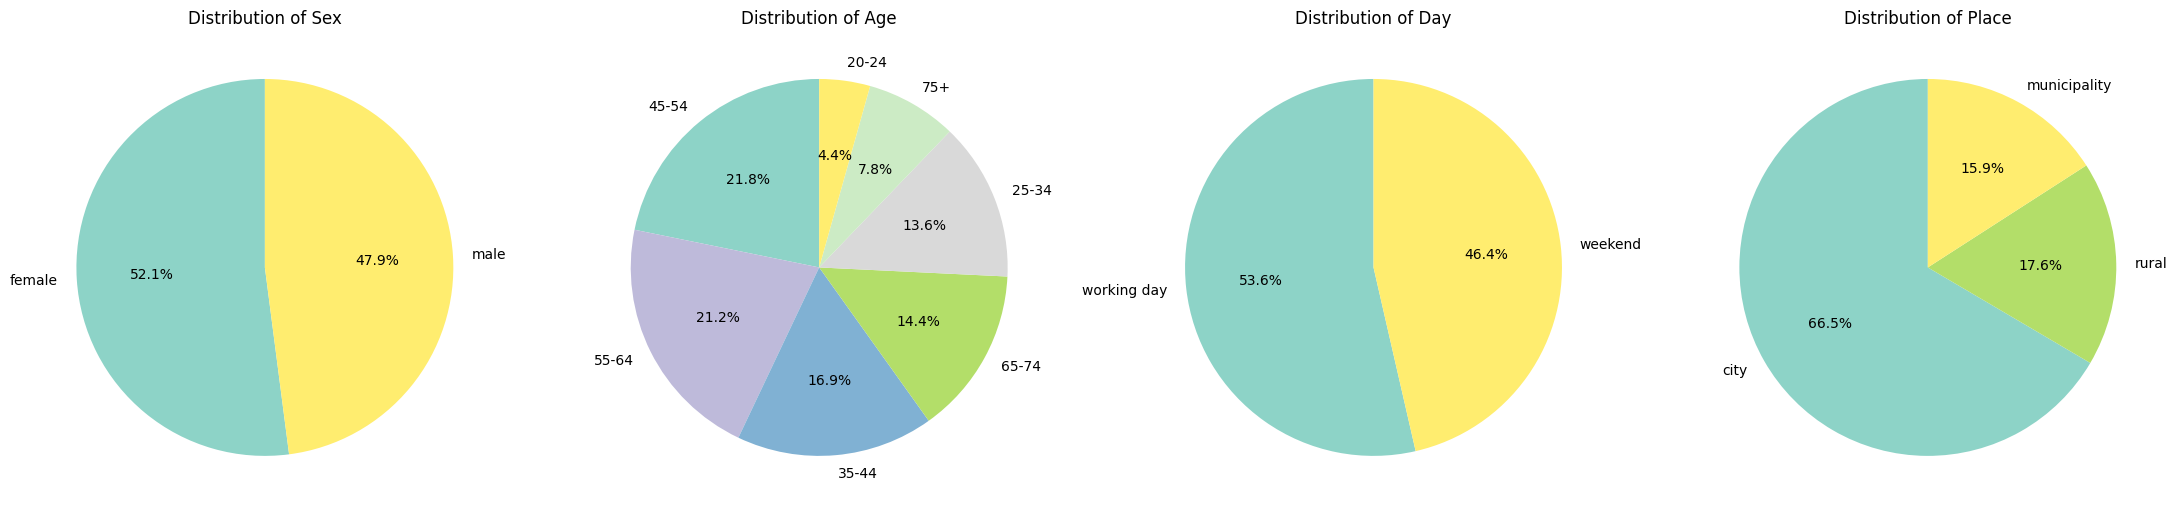

In [ ]:
plt.figure(figsize=(22, 6))
i = 0
for column in demographic_columns:
    plt.subplot(1, len(demographic_columns), i + 1)
    df[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
    plt.title(f'Distribution of {column.capitalize()}')
    plt.ylabel('')
    i += 1
plt.tight_layout()

In [ ]:
# Calculate the average time spent on each activity per household
household_average_activity_time = df.groupby('household_ID', observed=False)[numerical_columns].sum()

# Calculate the cummulative average time spent on activities
# Asnwer to the question "Estimate how much time on average households spend daily on each activity"
average_activity_time = household_average_activity_time.mean(axis=0)
print(average_activity_time)

working           165.989879
studying            3.623482
washing_dishes     17.406883
watching_TV       232.301619
dtype: Float64


In [ ]:
# Grouped by summary statistics for numerical variables based on each of the demographic variables
summary_stats = ['count', 'mean', 'std', 'min', 'max']
for col in demographic_columns:
  grouped_summary = df.groupby([col], observed=False)[numerical_columns].describe().loc[:, (slice(None), summary_stats)]

  styled_summary = grouped_summary.style.format("{:.2f}") \
                                        .set_caption(f"Summary Statistics for Activities by {col.capitalize()}") \
                                        .background_gradient(cmap="YlGnBu", subset=pd.IndexSlice[:, pd.IndexSlice[:, :]])

  display(styled_summary)

In [ ]:
# Grouped by summary statistics for numerical variables based on all of the demographic variables
summary_stats = ['count', 'mean', 'std', 'min', 'max']
grouped_summary = df.groupby(demographic_columns, observed=False)[numerical_columns].describe().loc[:, (slice(None), summary_stats)]

# Modify the styling to correctly access the 'mean' level in the MultiIndex
styled_summary = grouped_summary.style.format("{:.2f}") \
                                      .set_caption(f"Summary Statistics for Activities") \
                                      .background_gradient(cmap="YlGnBu", subset=pd.IndexSlice[:, pd.IndexSlice[:, :]]) \
                                      .highlight_max(axis=0, color="lightcoral", subset=pd.IndexSlice[:, pd.IndexSlice[:, :]]) # Apply to all columns within each level

display(styled_summary)

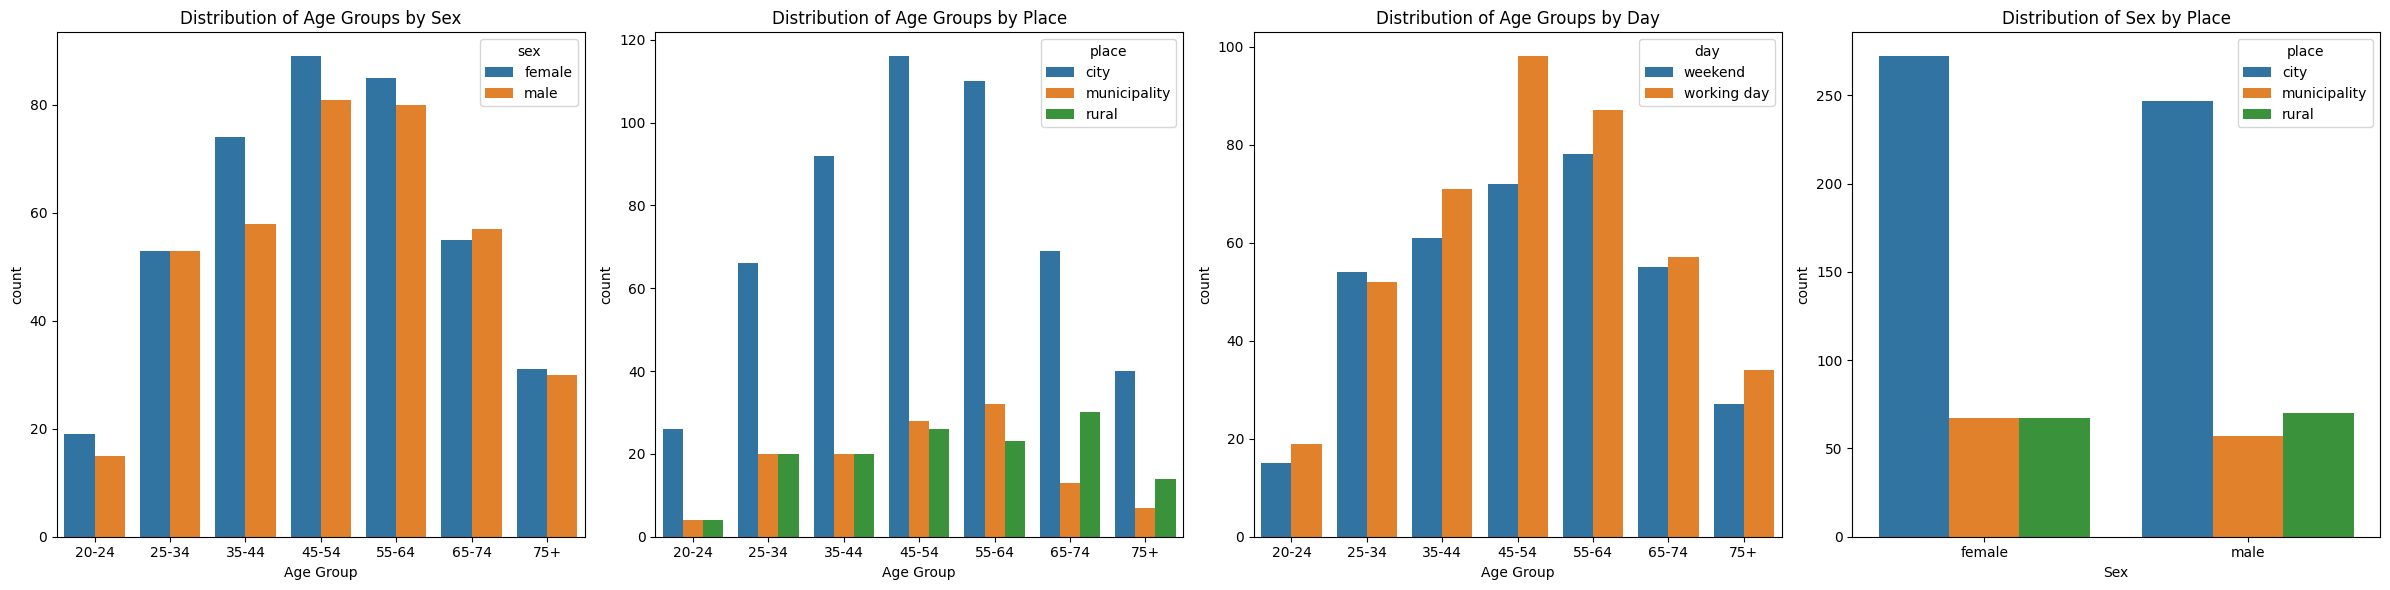

In [ ]:
# General distribution of age groups, age groups based on gender, age groups based on place, and gender based on place
x_columns = ['age', 'age', 'age', 'sex']
y_columns = ['sex', 'place', 'day', 'place']
titles = ['Distribution of Age Groups by Sex', 'Distribution of Age Groups by Place', 'Distribution of Age Groups by Day', 'Distribution of Sex by Place']
x_labels = ['Age Group', 'Age Group', 'Age Group', 'Sex']

countplots(x_columns, y_columns, titles, x_labels)

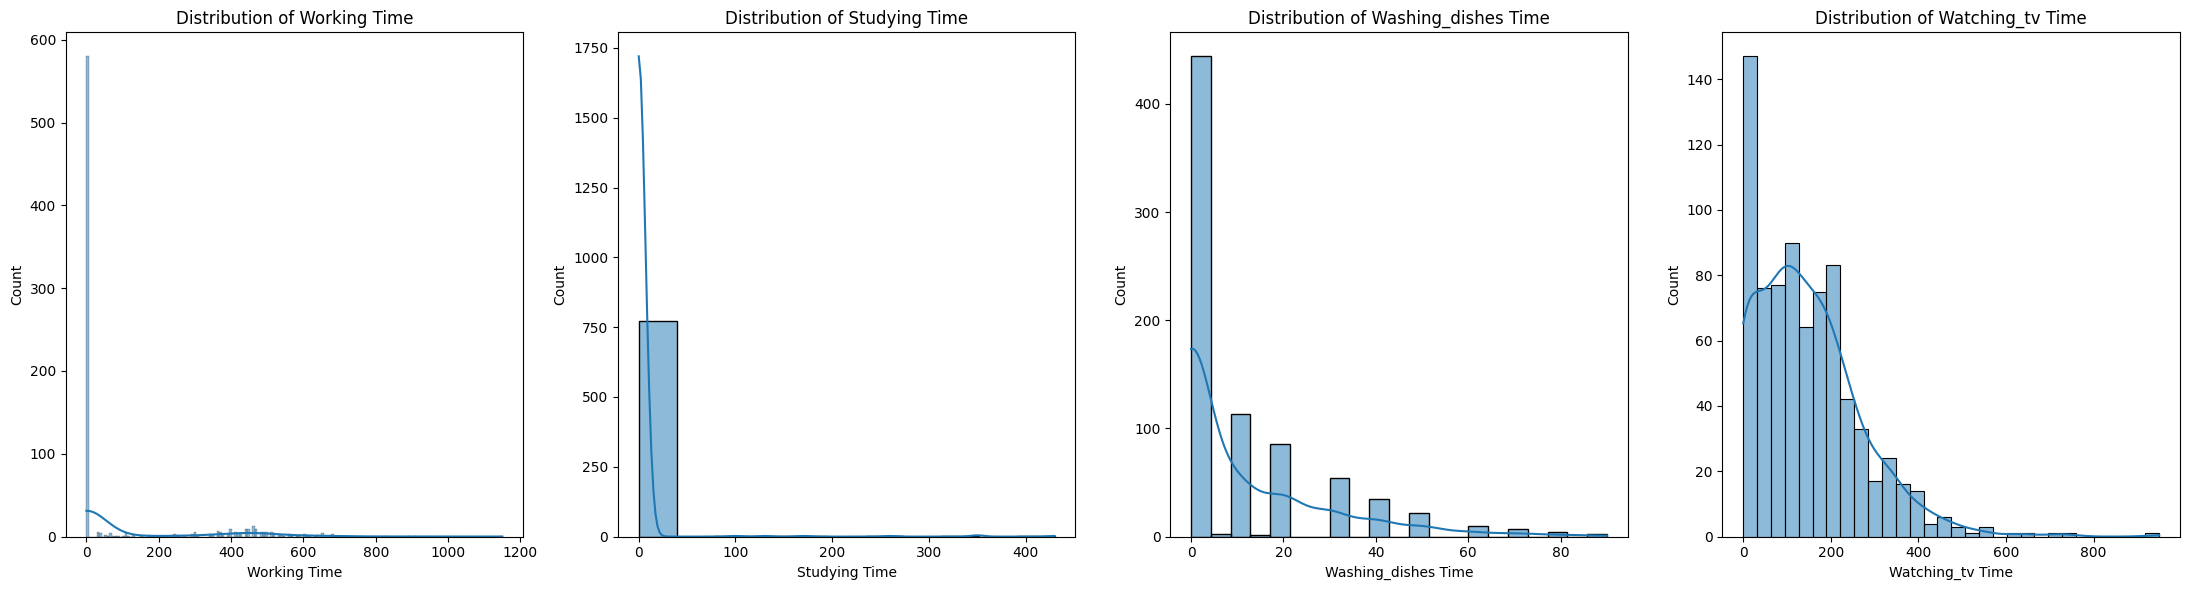

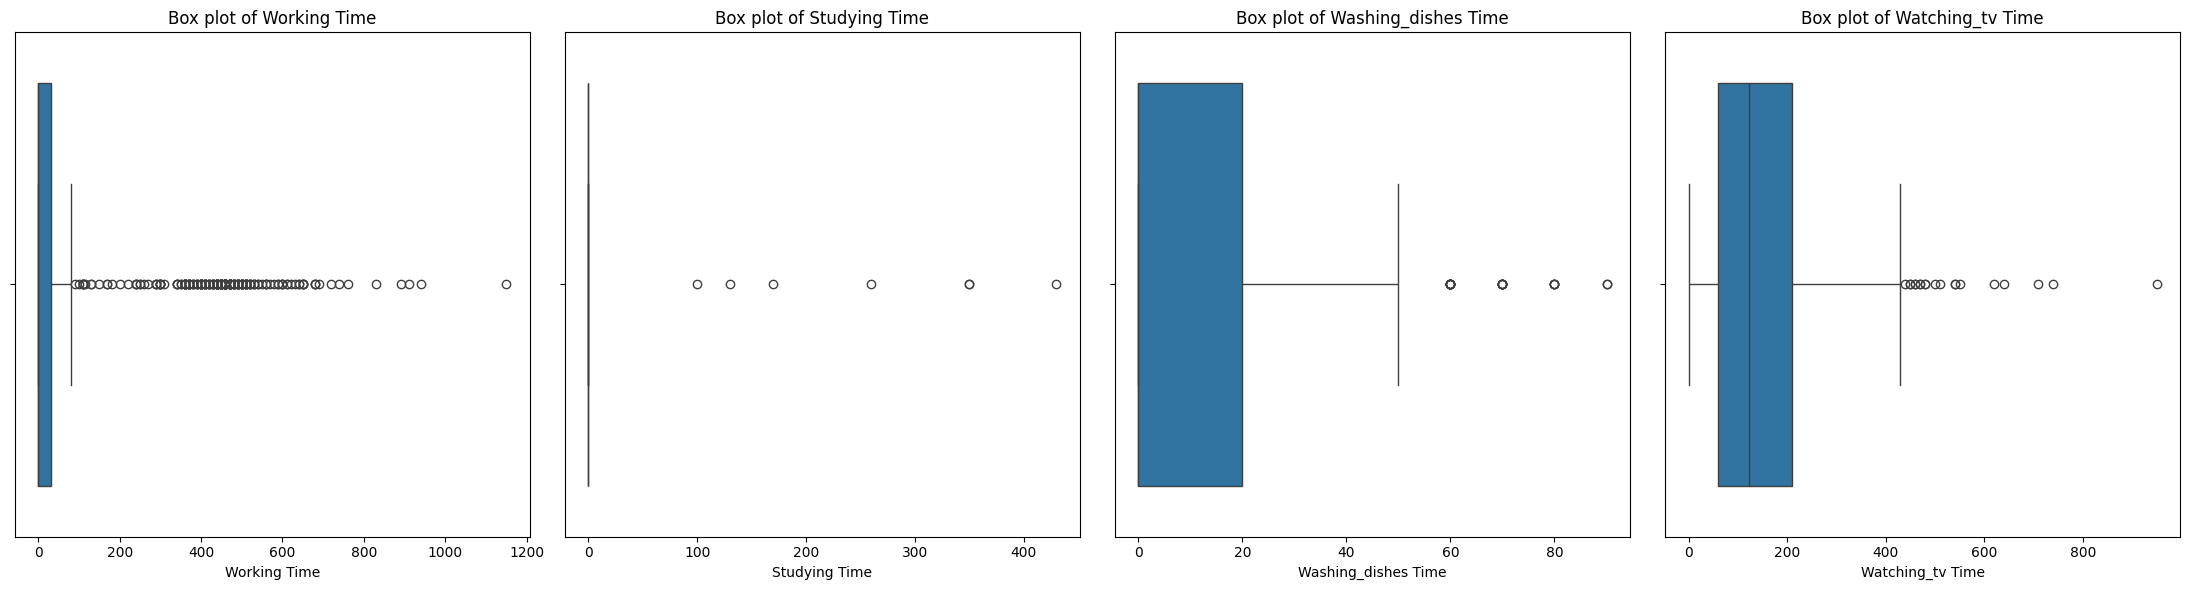

In [ ]:
# Histograms of working, studying, washing dishes and watching tv
plt.figure(figsize=(22, 6))
i = 0
for column in numerical_columns:
    plt.subplot(1, len(numerical_columns), i + 1)
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {column.capitalize()} Time')
    plt.xlabel(f'{column.capitalize()} Time')
    i += 1
plt.tight_layout()

# Box plots of working, studying, washing dishes and watching tv
plt.figure(figsize=(22, 6))
i = 0
for column in numerical_columns:
    plt.subplot(1, len(numerical_columns), i + 1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box plot of {column.capitalize()} Time')
    plt.xlabel(f'{column.capitalize()} Time')
    i += 1

plt.tight_layout()

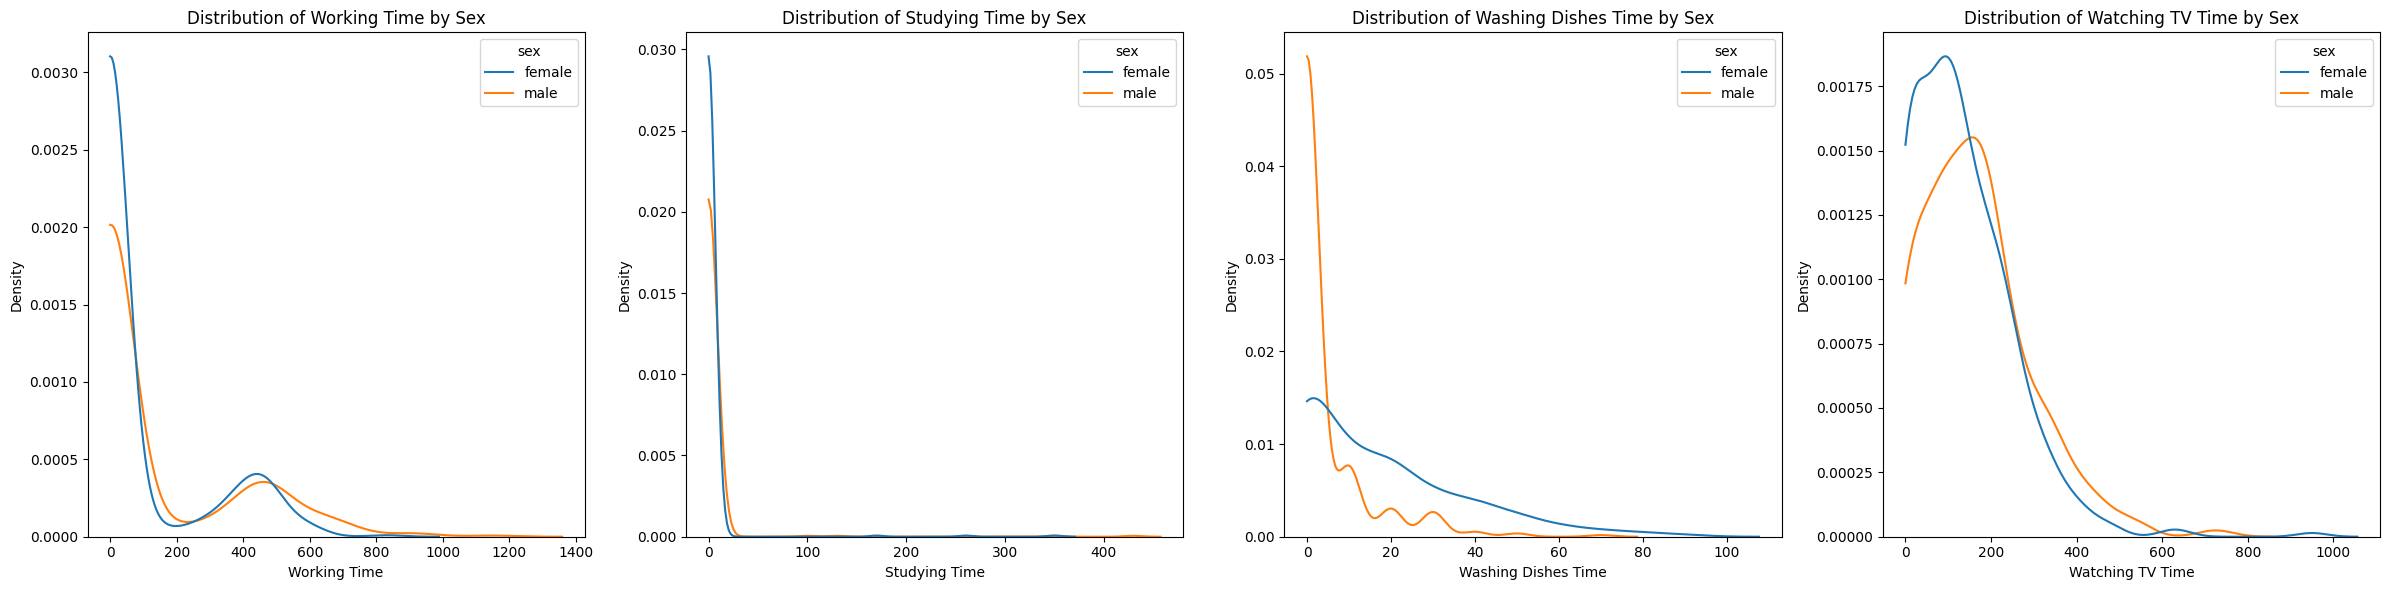

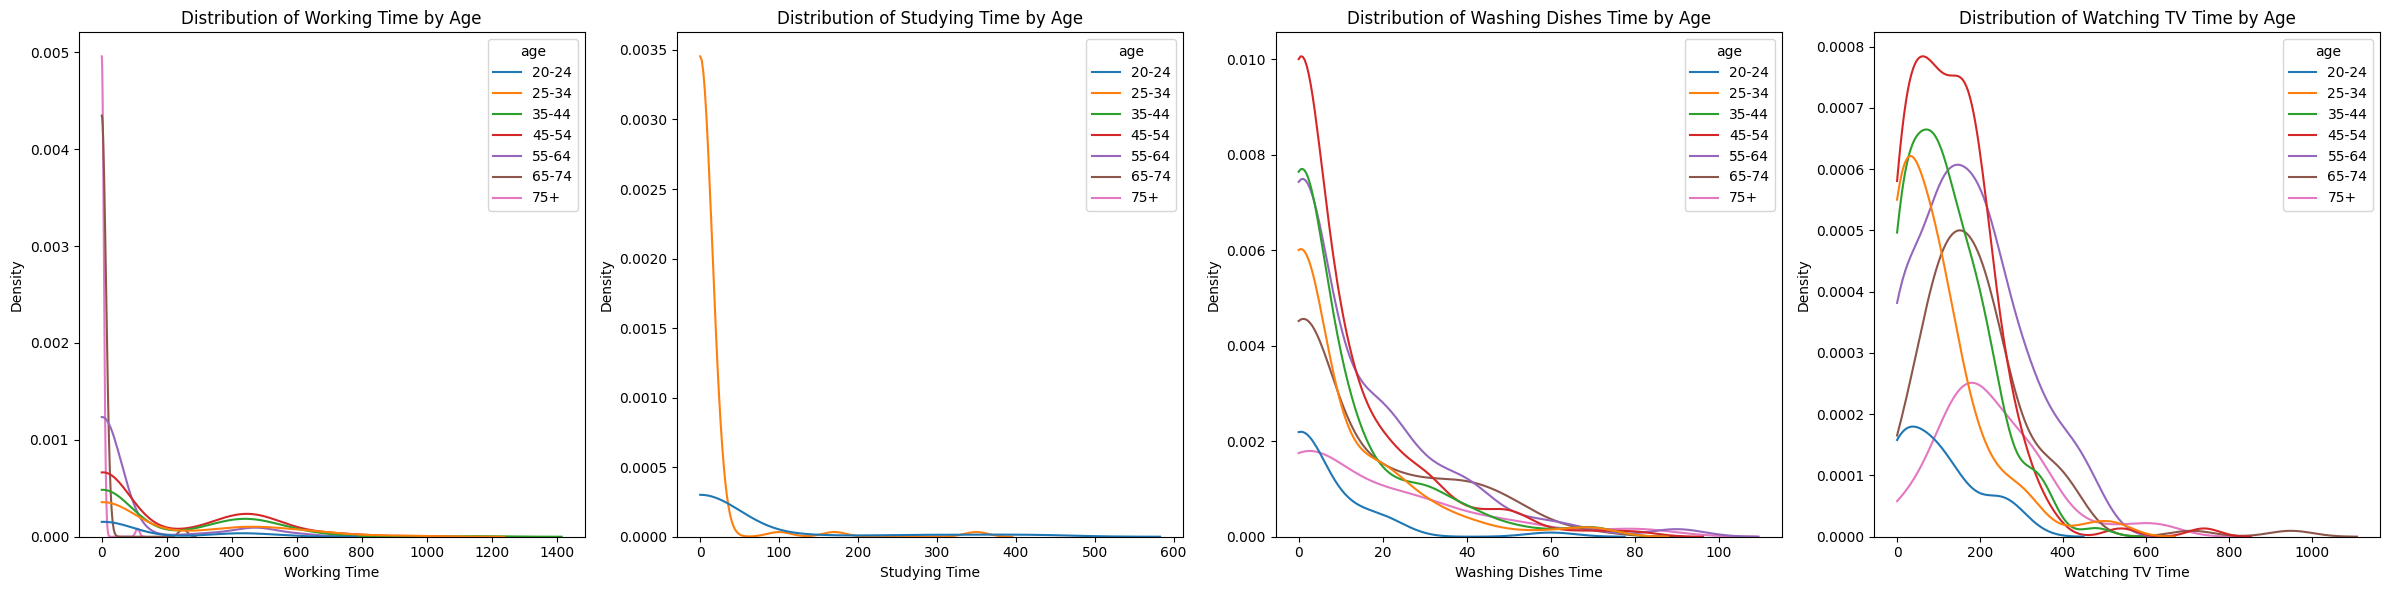

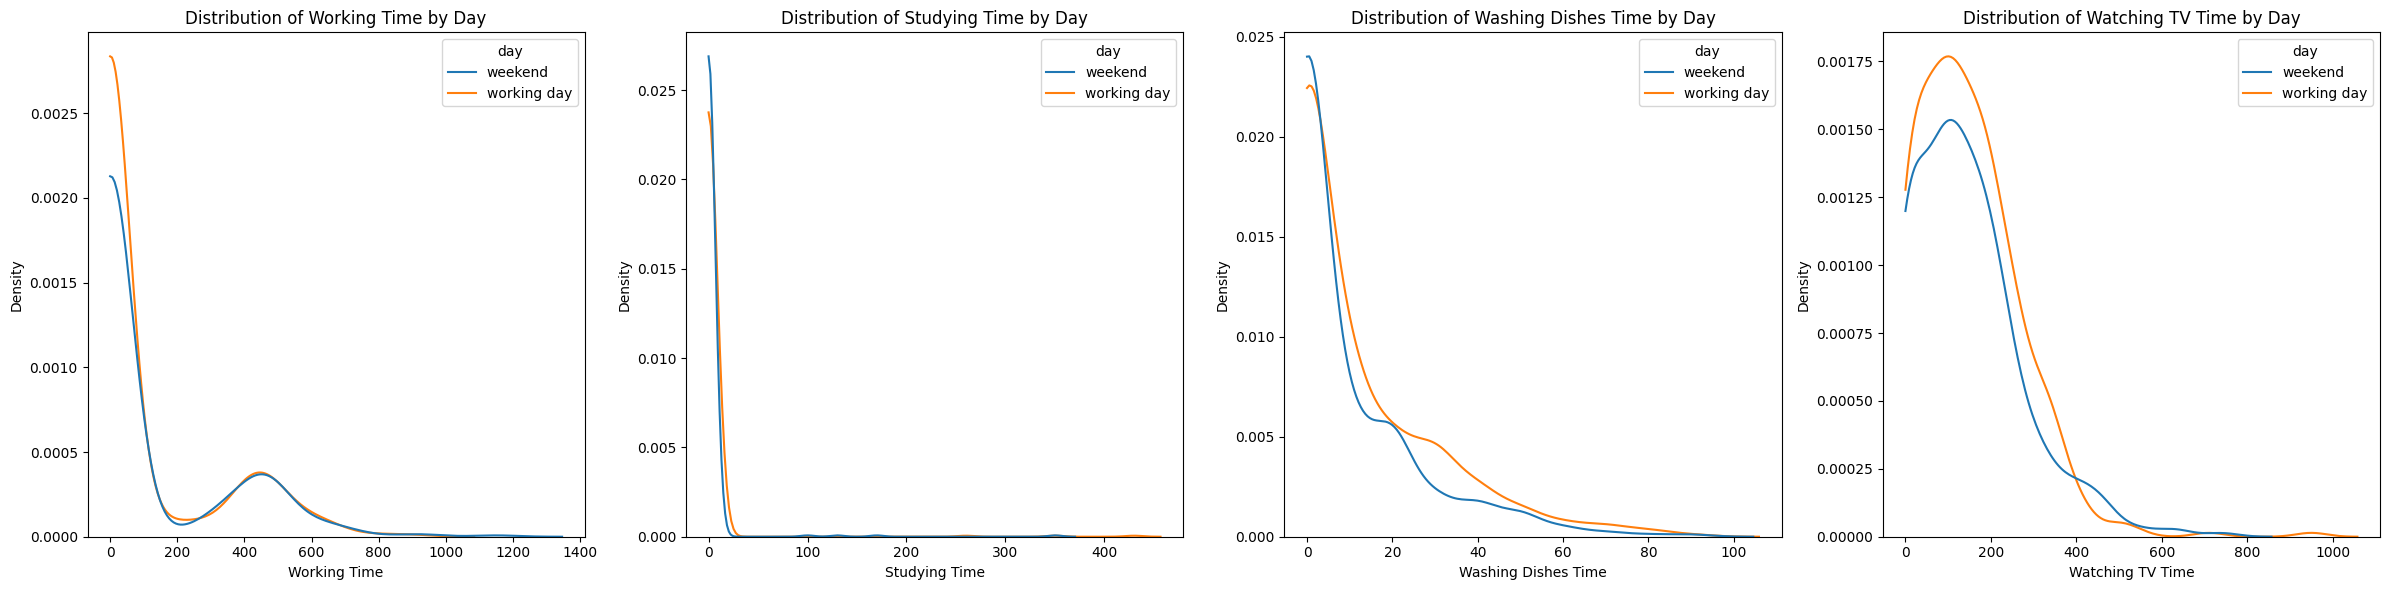

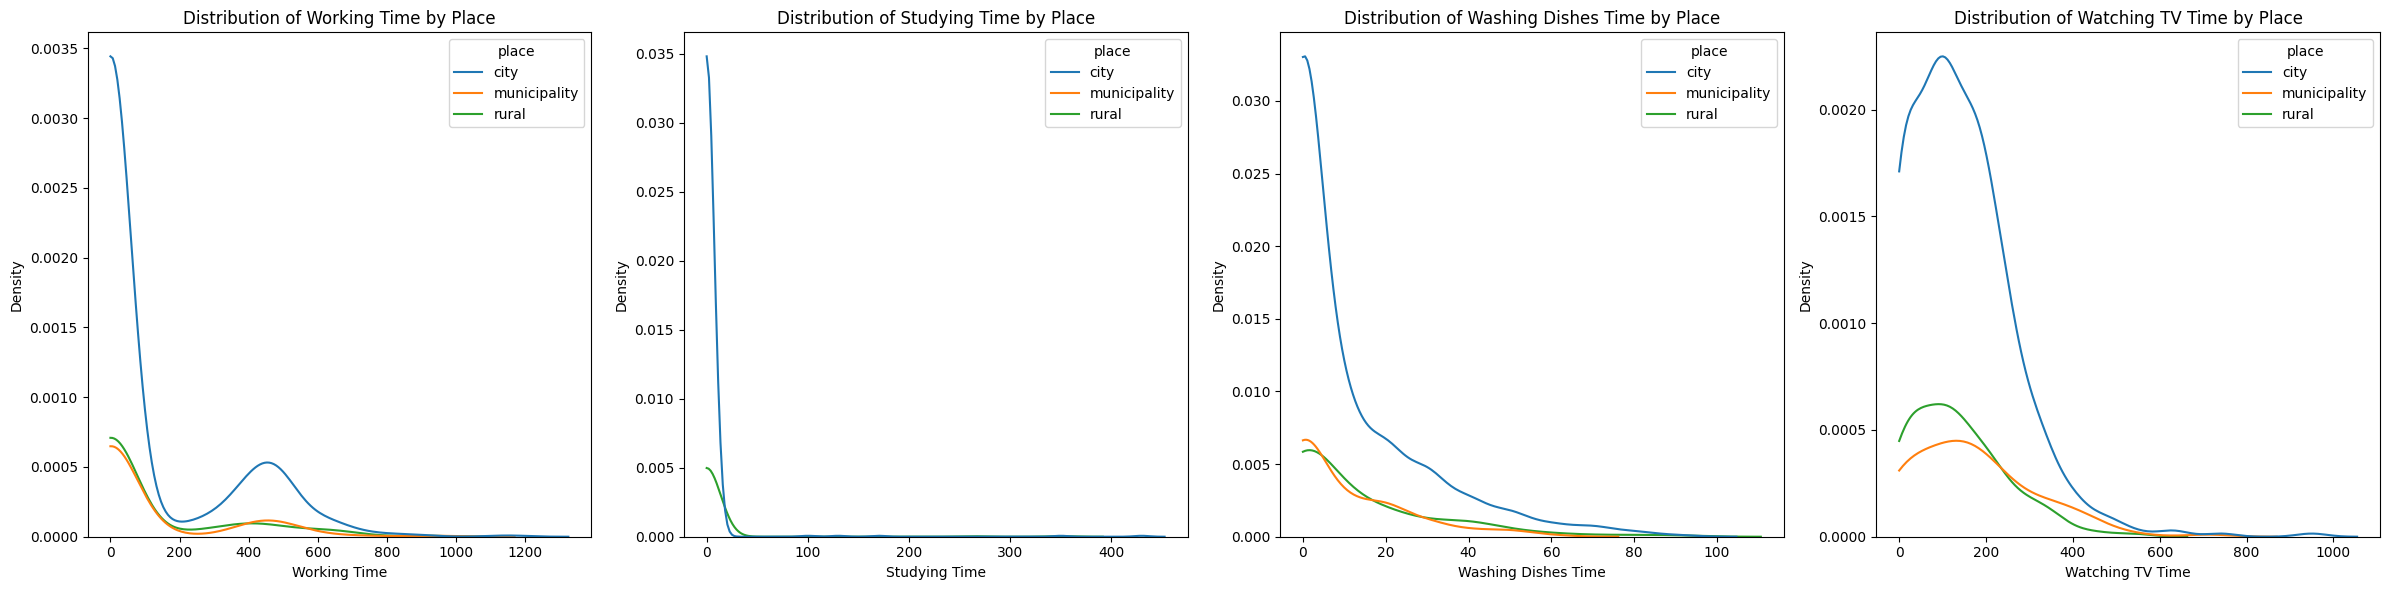

In [ ]:
# Distributions of working, studying, washing dishes and watching tv based on gender, age, day and place
x_columns = numerical_columns

for col in demographic_columns:
  y_columns = len(x_columns) * [col]
  name = col.capitalize()
  titles = [f'Distribution of Working Time by {name}', f'Distribution of Studying Time by {name}', f'Distribution of Washing Dishes Time by {name}', f'Distribution of Watching TV Time by {name}']
  x_labels = ['Working Time', 'Studying Time', 'Washing Dishes Time', 'Watching TV Time']

  kdeplots(x_columns, y_columns, titles, x_labels)

### K Means

In [ ]:
k_means_data = df.copy()

scaler = StandardScaler()
k_means_scaled_data = scaler.fit_transform(k_means_data[numerical_columns])

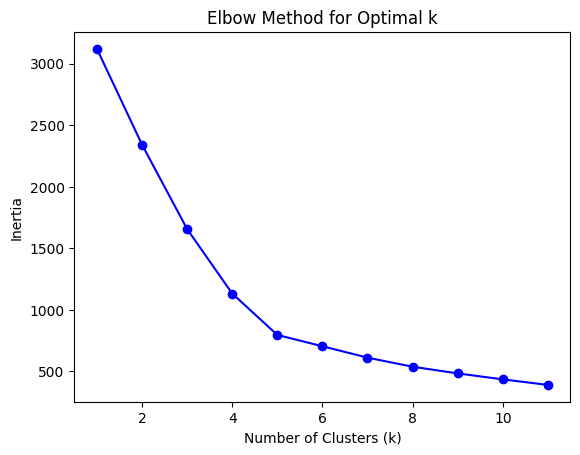

In [ ]:
# Range of k values to try
inertia_values = []
K_range = range(1, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(k_means_scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plotting the results
plt.plot(K_range, inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

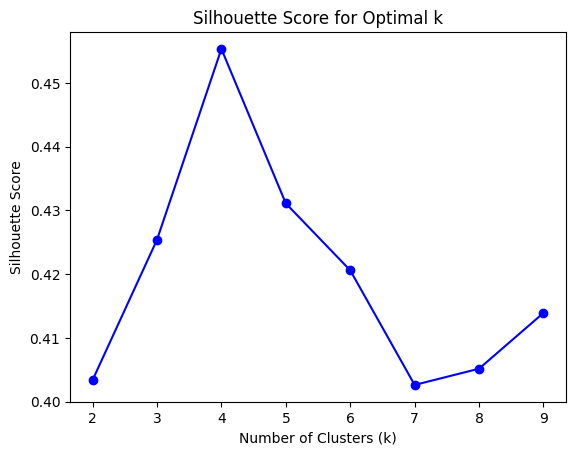

In [ ]:
silhouette_scores = []
silhouette_range = range(2, 10)
for k in silhouette_range:  # Starting from 2 as silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(k_means_scaled_data)
    silhouette_avg = silhouette_score(k_means_scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(silhouette_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

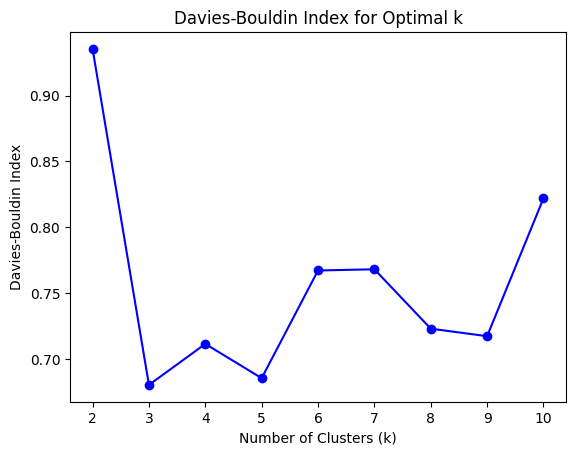

In [ ]:
davies_bouldin_scores = []
db_range = range(2, 11)
for k in db_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(k_means_scaled_data)
    db_score = davies_bouldin_score(k_means_scaled_data, cluster_labels)
    davies_bouldin_scores.append(db_score)

plt.plot(db_range, davies_bouldin_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
k_means_data['cluster'] = kmeans.fit_predict(k_means_scaled_data)

In [ ]:
# Access the cluster sizes
cluster_sizes = k_means_data['cluster'].value_counts()

# Print the size of each cluster
print(cluster_sizes)

cluster
1    321
4    171
0    161
3    123
2      4
Name: count, dtype: int64


In [ ]:
# Analyze clusters by checking the characteristics of columns within each cluster
# Get a summary of categorical columns within each cluster
categorical_columns = ['sex', 'age', 'day', 'place', 'cinema', 'sport']
extended_demographic_columns = ['cluster'] + demographic_columns

cluster_summary = k_means_data.groupby('cluster', observed=False)[categorical_columns].agg(lambda x: x.value_counts().index[0])

# Display cluster summaries
print("Cluster summary based on most common categorical values in each group:")
print(cluster_summary)

# Show average values of numerical columns per cluster
numerical_summary = k_means_data.groupby('cluster', observed=False)[numerical_columns].mean()
print("\nNumerical summary (mean values) per cluster:")
print(numerical_summary)

Cluster summary based on most common categorical values in each group:
            sex    age          day place cinema sport
cluster                                               
0          male  45-54      weekend  city    yes   yes
1          male  55-64  working day  city     no    no
2        female  20-24  working day  city    yes    no
3        female  65-74  working day  city     no    no
4          male  55-64  working day  city     no    no

Numerical summary (mean values) per cluster:
            working  studying  washing_dishes  watching_TV
cluster                                                   
0        478.695652       0.0        4.180124    86.192547
1          5.479751  1.246106        4.685358     98.23053
2              15.0     347.5             2.5         30.0
3          9.105691       0.0       43.658537   127.463415
4         11.637427       0.0        6.093567   313.157895


In [ ]:
# Grouped cluster summary
grouped_summary = k_means_data.groupby(extended_demographic_columns, observed=False)[numerical_columns].describe().loc[:, (slice(None), summary_stats)]
styled_summary = grouped_summary.style.format("{:.2f}") \
                                      .set_caption(f"Summary Statistics for Activities by cluster") \
                                      .background_gradient(cmap="YlGnBu", subset=pd.IndexSlice[:, pd.IndexSlice[:, :]])

display(styled_summary)

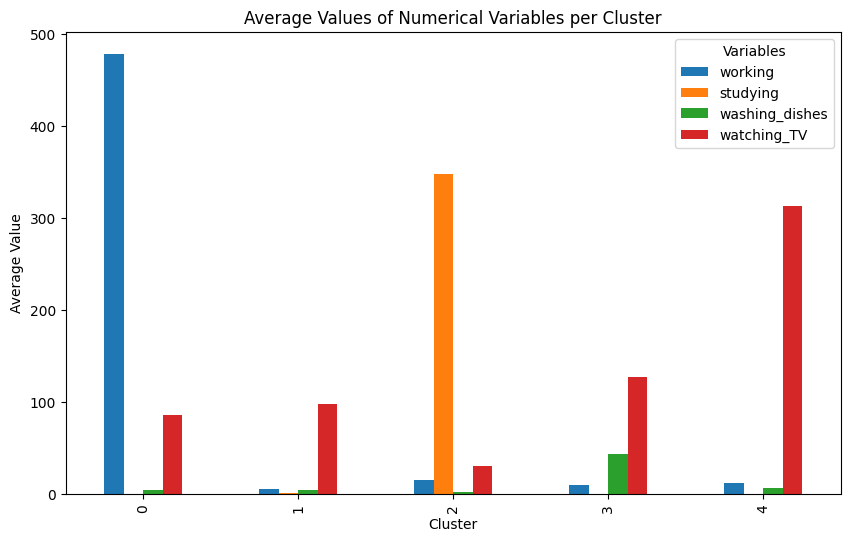

In [ ]:
# Plot cluster centers for numerical columns
numerical_summary.plot(kind='bar', figsize=(10, 6))
plt.title('Average Values of Numerical Variables per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.legend(title='Variables')
plt.show()

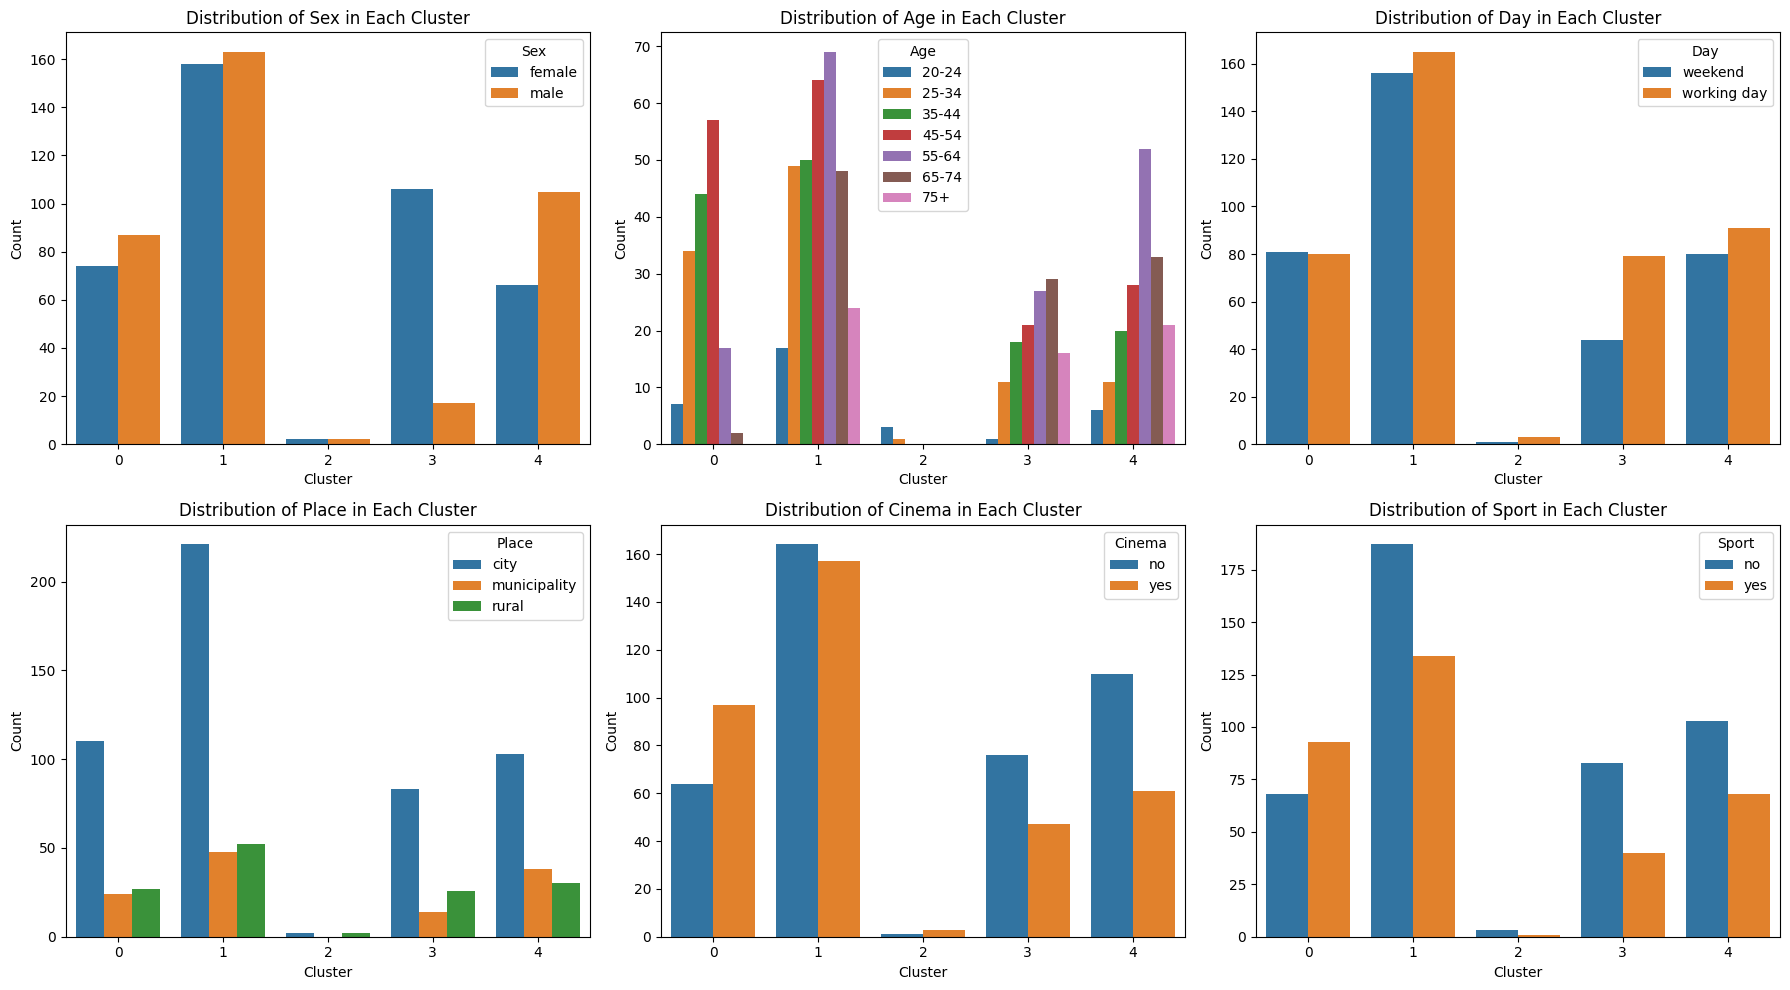

In [ ]:
# Create a plot for each categorical attribute to show cluster composition
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=k_means_data, x='cluster', hue=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.capitalize()} in Each Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col.capitalize())

plt.tight_layout()
plt.show()

Explained variance by PCA components: [0.32617119 0.2610285 ] - sum 0.5871996924536714


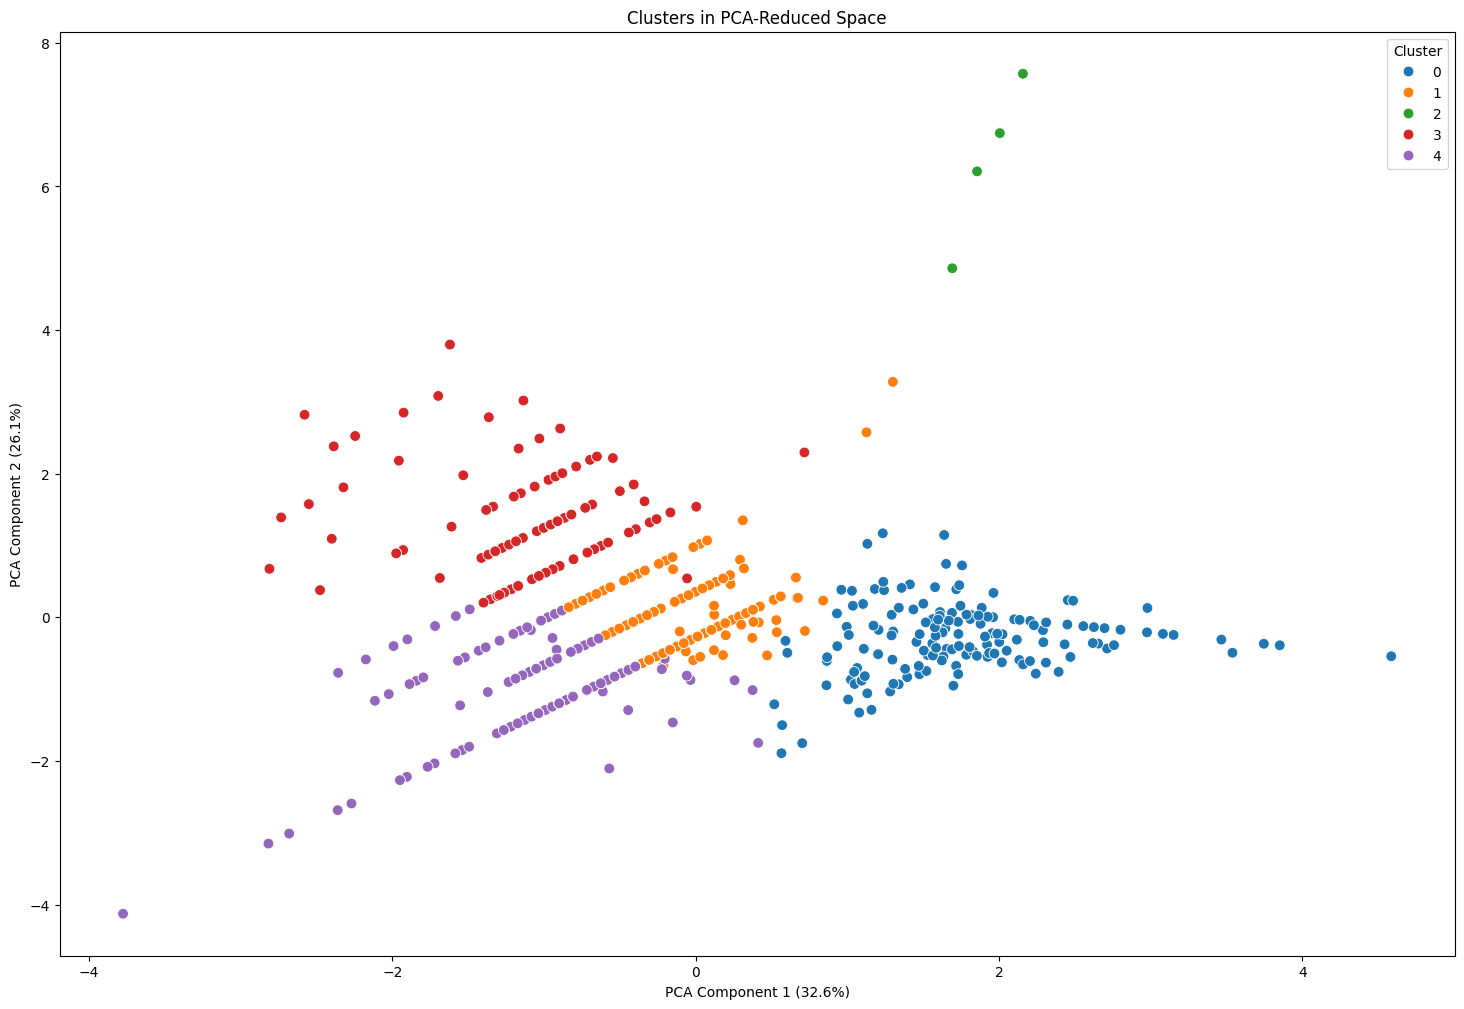

In [ ]:
# Perform PCA on numerical columns to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(k_means_scaled_data)

# Add PCA components to the DataFrame for plotting
k_means_data['PCA1'] = pca_components[:, 0]
k_means_data['PCA2'] = pca_components[:, 1]

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance} - sum {explained_variance[0] + explained_variance[1]}")

# Plot the clusters in PCA space
plt.figure(figsize=(18, 12))
sns.scatterplot(data=k_means_data, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters in PCA-Reduced Space')
plt.xlabel(f'PCA Component 1 ({explained_variance[0]*100:.1f}%)')
plt.ylabel(f'PCA Component 2 ({explained_variance[1]*100:.1f}%)')
plt.legend(title='Cluster')
plt.show()

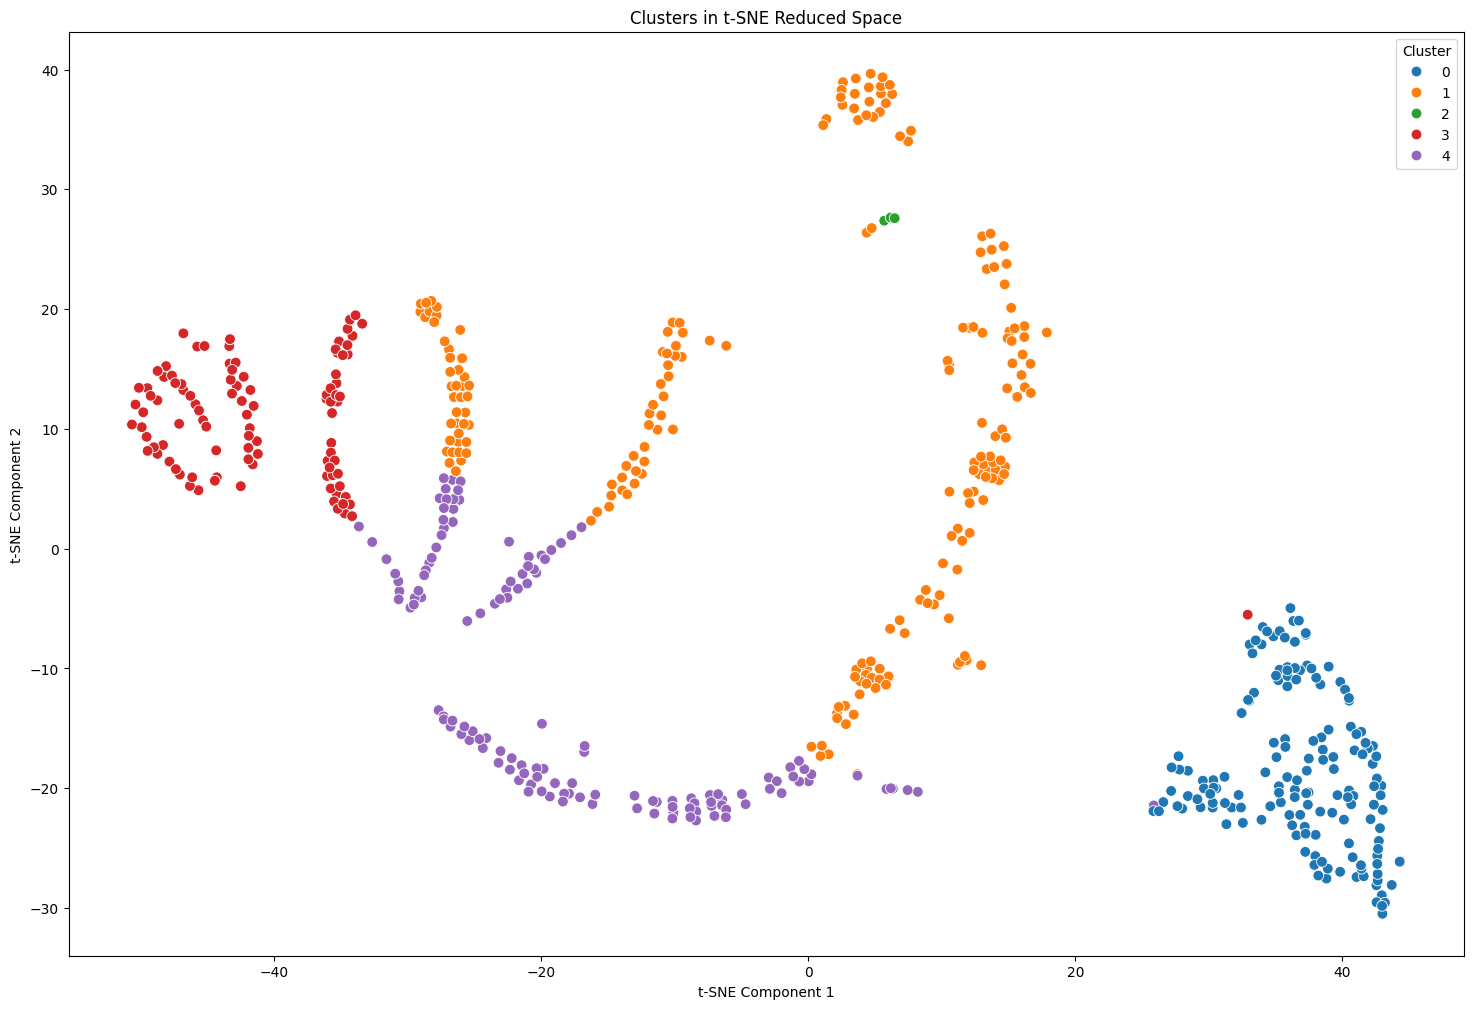

In [ ]:
# Using t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(k_means_scaled_data)

# Add t-SNE components to the DataFrame for plotting
k_means_data['t-SNE1'] = tsne_components[:, 0]
k_means_data['t-SNE2'] = tsne_components[:, 1]

# Plot t-SNE result
plt.figure(figsize=(18, 12))
sns.scatterplot(data=k_means_data, x='t-SNE1', y='t-SNE2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters in t-SNE Reduced Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

## Statistical Testing

In [ ]:
df = df_cleaned.copy()
demographic_columns = ['sex', 'age', 'day', 'place']
numerical_columns = ['working', 'studying', 'washing_dishes', 'watching_TV']

### Normality Testing

In [ ]:
for col in numerical_columns:
  print(f"\n{col.capitalize()}")
  print_normality_test_results(df[col], f"{col} is normally distributed")


Working
Statistics=0.576, p=0.000
H0: working is normally distributed
Sample does not look Gaussian (reject H0)

Studying
Statistics=0.060, p=0.000
H0: studying is normally distributed
Sample does not look Gaussian (reject H0)

Washing_dishes
Statistics=0.703, p=0.000
H0: washing_dishes is normally distributed
Sample does not look Gaussian (reject H0)

Watching_tv
Statistics=0.907, p=0.000
H0: watching_TV is normally distributed
Sample does not look Gaussian (reject H0)


### Correlation Analysis

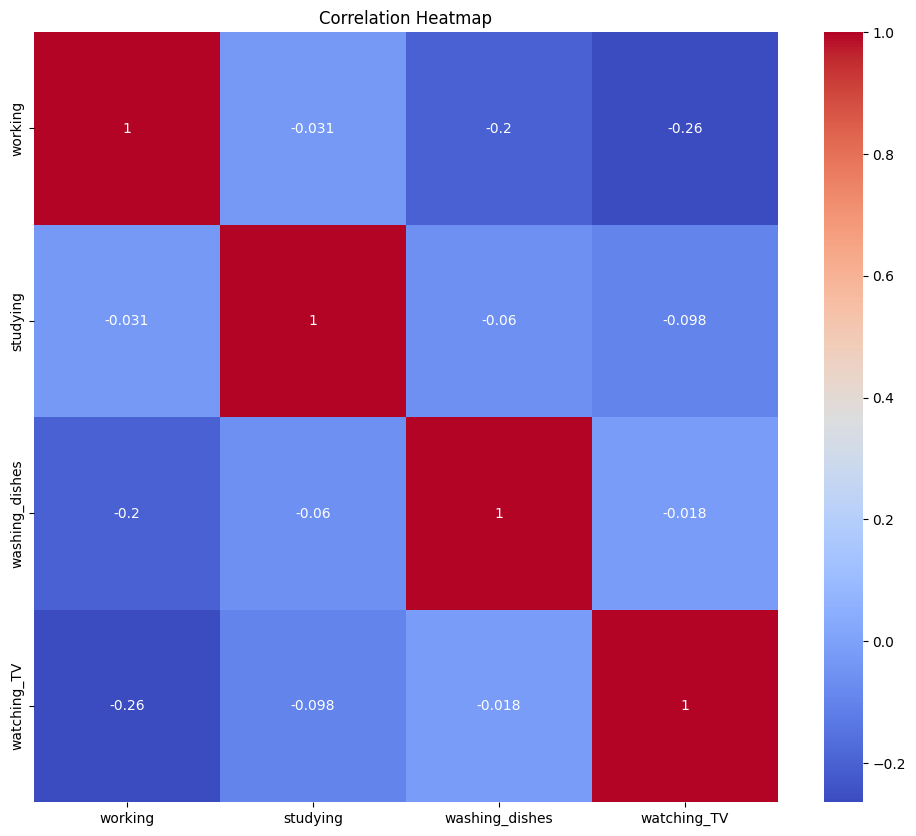

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_columns].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Correlation tests - spearman since the values are not normally distributed
for col in numerical_columns:
  print(f"\n{col.capitalize()}")
  for col2 in numerical_columns:
    if col != col2:
      stat, p = spearmanr(df[col], df[col2])
      print_test_results(stat, p, f"{col} and {col2} are not correlated - spearman")


Working
Statistics=-0.031, p=0.383
H0: working and studying are not correlated - spearman
Fail to reject H0. There is no statistically significant difference between the groups.
Statistics=-0.203, p=0.000
H0: working and washing_dishes are not correlated - spearman
Reject H0. There is a statistically significant difference between the groups.
Statistics=-0.264, p=0.000
H0: working and watching_TV are not correlated - spearman
Reject H0. There is a statistically significant difference between the groups.

Studying
Statistics=-0.031, p=0.383
H0: studying and working are not correlated - spearman
Fail to reject H0. There is no statistically significant difference between the groups.
Statistics=-0.060, p=0.091
H0: studying and washing_dishes are not correlated - spearman
Fail to reject H0. There is no statistically significant difference between the groups.
Statistics=-0.098, p=0.006
H0: studying and watching_TV are not correlated - spearman
Reject H0. There is a statistically significant

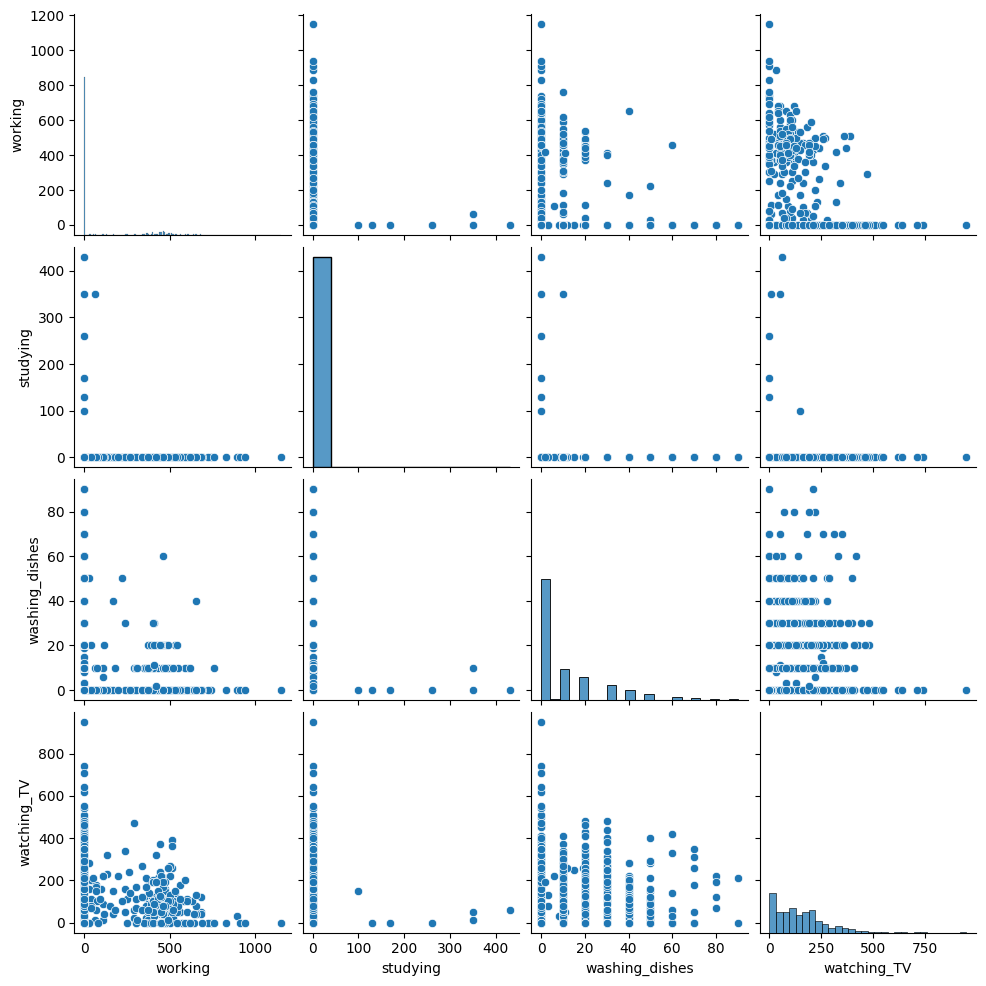

In [ ]:
sns.pairplot(df, vars=numerical_columns)

### Statistical Comparison

####  Mann-Whitney U test

In [ ]:
# Mann-Whitney U test for statistical testing between different genders and numerical columns
# Collect p-values for multiple tests
p_values = []
test_results = []

for col in numerical_columns:
  female_column = df[df['sex'] == 'female'][col]
  male_column = df[df['sex'] == 'male'][col]

  statistic, p_value = mannwhitneyu(female_column, male_column, alternative='two-sided')
  p_values.append(p_value)
  test_results.append((col, statistic, p_value))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col, stat, p), adj_p in zip(test_results, adjusted_p_values):
  print_test_results(stat, p, f"{col.capitalize()} time between females and males is the same", adj_p)
  print("")

Statistics=70204.000, p=0.018, p_adj=0.024
H0: Working time between females and males is the same
Reject H0. There is a statistically significant difference between the groups.

Statistics=75671.500, p=0.626, p_adj=0.626
H0: Studying time between females and males is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=110232.500, p=0.000, p_adj=0.000
H0: Washing_dishes time between females and males is the same
Reject H0. There is a statistically significant difference between the groups.

Statistics=64519.000, p=0.000, p_adj=0.001
H0: Watching_tv time between females and males is the same
Reject H0. There is a statistically significant difference between the groups.



In [ ]:
# Mann-Whitney U test for statistical testing between different days and numerical columns
# Collect p-values for multiple tests
p_values = []
test_results = []

for col in numerical_columns:
  working_day_column = df[df['day'] == 'working day'][col]
  weekend_column = df[df['day'] == 'weekend'][col]

  statistic, p_value = mannwhitneyu(working_day_column, weekend_column, alternative='two-sided')
  p_values.append(p_value)
  test_results.append((col, statistic, p_value))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col, stat, p), adj_p in zip(test_results, adjusted_p_values):
  print_test_results(stat, p, f"{col.capitalize()} time between working days and weekends is the same", adj_p)
  print("")

Statistics=73746.000, p=0.427, p_adj=0.570
H0: Working time between working days and weekends is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=75369.500, p=0.574, p_adj=0.574
H0: Studying time between working days and weekends is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=82465.500, p=0.016, p_adj=0.065
H0: Washing_dishes time between working days and weekends is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=78188.000, p=0.419, p_adj=0.570
H0: Watching_tv time between working days and weekends is the same
Fail to reject H0. There is no statistically significant difference between the groups.



#### Kruskal-Wallis test

In [ ]:
# Perform Kruskal-Wallis test for different places and numerical columns
# Collect p-values for multiple tests
p_values = []
test_results = []

for col in numerical_columns:
  city_column = df[df['place'] == 'city'][col]
  municipality_column = df[df['place'] == 'municipality'][col]
  rural_column = df[df['place'] == 'rural'][col]

  statistic, p_value = kruskal(city_column, municipality_column, rural_column)
  p_values.append(p_value)
  test_results.append((col, statistic, p_value))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col, stat, p), adj_p in zip(test_results, adjusted_p_values):
  print_test_results(stat, p, f"{col.capitalize()} time median between different places is the same", adj_p)
  print("")

Statistics=0.254, p=0.881, p_adj=0.881
H0: Working time median between different places is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=1.638, p=0.441, p_adj=0.588
H0: Studying time median between different places is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=2.895, p=0.235, p_adj=0.470
H0: Washing_dishes time median between different places is the same
Fail to reject H0. There is no statistically significant difference between the groups.

Statistics=4.193, p=0.123, p_adj=0.470
H0: Watching_tv time median between different places is the same
Fail to reject H0. There is no statistically significant difference between the groups.



In [ ]:
# Perform Kruskal-Wallis test for different age groups and numerical columns
# Collect p-values for multiple tests
p_values = []
test_results = []

for col in numerical_columns:
  age_20_24_column = df[df['age'] == '20-24'][col]
  age_25_34_column = df[df['age'] == '25-34'][col]
  age_35_44_column = df[df['age'] == '35-44'][col]
  age_45_54_column = df[df['age'] == '45-54'][col]
  age_55_64_column = df[df['age'] == '55-64'][col]
  age_65_74_column = df[df['age'] == '65-74'][col]
  age_75_column = df[df['age'] == '75+'][col]

  statistic, p_value = kruskal(age_20_24_column, age_25_34_column, age_35_44_column, age_45_54_column,age_55_64_column,age_65_74_column,age_75_column)
  p_values.append(p_value)
  test_results.append((col, statistic, p_value))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col, stat, p), adj_p in zip(test_results, adjusted_p_values):
  print_test_results(stat, p, f"{col.capitalize()} time median between different age groups is the same", adj_p)
  print("")

Statistics=100.411, p=0.000, p_adj=0.000
H0: Working time median between different age groups is the same
Reject H0. There is a statistically significant difference between the groups.

Statistics=55.451, p=0.000, p_adj=0.000
H0: Studying time median between different age groups is the same
Reject H0. There is a statistically significant difference between the groups.

Statistics=17.342, p=0.008, p_adj=0.008
H0: Washing_dishes time median between different age groups is the same
Reject H0. There is a statistically significant difference between the groups.

Statistics=88.753, p=0.000, p_adj=0.000
H0: Watching_tv time median between different age groups is the same
Reject H0. There is a statistically significant difference between the groups.



####  Wilcoxon signed-rank test

In [ ]:
# Perform the Wilcoxon signed-rank test because data in rows belongs to the same family
# Collect p-values for multiple tests
p_values = []
test_results = []

for i in range(len(numerical_columns)):
  for j in range(i + 1, len(numerical_columns)):
    data1 = df[numerical_columns[i]]
    data2 = df[numerical_columns[j]]

    statistic, p_value = wilcoxon(data1, data2)
    p_values.append(p_value)
    test_results.append((numerical_columns[i], numerical_columns[j], statistic, p_value))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col1, col2, stat, p), adj_p in zip(test_results, adjusted_p_values):
    print_test_results(stat, p, f"{numerical_columns[i].capitalize()} and {numerical_columns[j].capitalize()} come from the same distribution", adj_p)
    print("")

Statistics=321.500, p=0.000, p_adj=0.000
H0: Watching_tv and Watching_tv come from the same distribution
Reject H0. There is a statistically significant difference between the groups.

Statistics=40511.500, p=0.000, p_adj=0.000
H0: Watching_tv and Watching_tv come from the same distribution
Reject H0. There is a statistically significant difference between the groups.

Statistics=92032.000, p=0.000, p_adj=0.000
H0: Watching_tv and Watching_tv come from the same distribution
Reject H0. There is a statistically significant difference between the groups.

Statistics=2394.000, p=0.000, p_adj=0.000
H0: Watching_tv and Watching_tv come from the same distribution
Reject H0. There is a statistically significant difference between the groups.

Statistics=3041.000, p=0.000, p_adj=0.000
H0: Watching_tv and Watching_tv come from the same distribution
Reject H0. There is a statistically significant difference between the groups.

Statistics=3762.000, p=0.000, p_adj=0.000
H0: Watching_tv and Watchin

#### Chi squared test

In [ ]:
# Chi squared test between pairs of categorical features
categorical_cols = ['sex', 'age', 'day', 'place', 'cinema', 'sport']

# Collect p-values for multiple tests
p_values = []
test_results = []

for i in range(len(categorical_cols)):
  for j in range(i + 1, len(categorical_cols)):
    col1 = categorical_cols[i]
    col2 = categorical_cols[j]
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    p_values.append(p)
    test_results.append((col1, col2, chi2, dof, p, contingency_table))

# Apply multiple testing correction (Benjamini-Hochberg)
adjusted_results = multipletests(p_values, method='fdr_bh')
adjusted_p_values = adjusted_results[1]

for (col1, col2, chi2, dof, p, contingency_table), adj_p in zip(test_results, adjusted_p_values):
  print(f"Chi-squared test for {col1} vs {col2}:")
  print(f"Degrees of freedom: {dof}")
  print("Contingency Table:")
  print(contingency_table)
  print("")
  print_test_results(chi2, p, f"{col1} and {col2} are independent of each other", adj_p)
  print("")

Chi-squared test for sex vs age:
Degrees of freedom: 6
Contingency Table:
age     20-24  25-34  35-44  45-54  55-64  65-74  75+
sex                                                  
female     19     53     74     89     85     55   31
male       15     53     58     81     80     57   30

Statistics=1.680, p=0.947, p_adj=0.947
H0: sex and age are independent of each other
Fail to reject H0. There is no statistically significant difference between the groups.

Chi-squared test for sex vs day:
Degrees of freedom: 1
Contingency Table:
day     weekend  working day
sex                         
female      183          223
male        179          195

Statistics=0.501, p=0.479, p_adj=0.599
H0: sex and day are independent of each other
Fail to reject H0. There is no statistically significant difference between the groups.

Chi-squared test for sex vs place:
Degrees of freedom: 2
Contingency Table:
place   city  municipality  rural
sex                              
female   272            67